# `Материалы кафедры ММП факультета ВМК МГУ. Введение в глубокое обучение.`

## `Задание 02. Сегментация изображений`

#### Фамилия, имя: Марьясов Максим

Дата выдачи: <span style="color:red">__3 марта 19:00__</span>.

Мягкий дедлайн: <span style="color:red">__17 марта 5:00__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __4.25 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2025`

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур `U-Net` и `LinkNet`. 

Данные для выполнения задания можно скачать по [ссылке](https://disk.yandex.ru/d/tI6d3LBMHTwOnw).

## `Загрузка данных (1 балл)`

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с ImageNet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс `PhotosDataset` для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [3]:
import os

import numpy as np
import numpy.testing as npt

import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg13, VGG13_Weights

import matplotlib_inline
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [4]:
from PIL import Image

class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None, image_transforms=None, target_transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images
            
        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.
            
        transforms : some collection
            Sequence of transformations for images and masks. 
        """
        super().__init__()
        self.images_dir = images_dir
        self.target_dir = target_dir
        
        self.img_paths = sorted(os.listdir(images_dir))
        
        if target_dir:
            self.target_paths = sorted(os.listdir(target_dir))

        self.transform = transforms
        self.image_transform = image_transforms
        self.target_transform = target_transforms
        
        
    def __len__(self):
        return len(self.img_paths)
                   
    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask
        
        Returns
        -------
        (image, mask)
        """
        path = self.img_paths[idx]
        img_path = os.path.join(self.images_dir, path)
        image = Image.open(img_path).convert('RGB')
        
        image_stem, _ = os.path.splitext(path)

        if self.target_paths:
            for mask_path in self.target_paths:
                if os.path.splitext(mask_path)[0] == image_stem:
                    mask_path = os.path.join(self.target_dir, mask_path)
                    break

        mask = Image.open(mask_path).convert('1')
        mask = mask.point(lambda p: 255 if p > 128 else 0)
        if self.transform:
            image, mask = self.transform((image, mask))
        if self.image_transform:
            image = self.image_transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)
        
        return image, mask

## `Модуль аугментации (2 балла)`

Конструктор стандартного `ImageFolder`, принимает параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в [документации](https://pytorch.org/vision/0.12/transforms.html).

В данной части вам предлагается самостоятельно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

1. случайное (с вероятностью $p$) горизонтальное отображение (flip) изображения 
2. случайное (с вероятностью $p$) вырезание фрагмента изображения (заданного или случайного размера)
3. случайное (с вероятностью $p$) изменение яркости изображения (на заданную или случайную величину)
4. случайное (с вероятностью $p$) изменение фона изображения (на изображение из заданного списка изображений)

Используйте разумные пределы для аугментаций. Одной из причин плохого обучения модели могут быть слишком сильные аугментации. Визуально убедитесь, что граничные случаи достаточно адекватны задаче.

Обратите внимание, что под вырезанием фрагмента подрузумевается вырезания части изображения из исходного, то есть вырезание какой-то части изображения (создание отверстий в изображении). Если после слоя вырезания размеры изображения поменялись, то вы неправильно реализовали модуль.

In [5]:
from PIL import ImageEnhance

# случайное горизонтальное отображение
class HorizontalFlip(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, pair):
        """
        Args:
            img (PIL.Image): Изображение для горизонтального отображения.
            mask (PIL.Image): Маска для горизонтального отображения.

        Returns:
            (image, mask)
            
            image: PIL.Image, Изображение, горизонтально отображенное с вероятностью p.
            mask: PIL.Image, Маска с аналогичным преобразованиями для изображения.
        """
        img, mask = pair
        if torch.rand(1).item() < self.p:
            return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT) 
        return img, mask
        
# случайное вырезание фрагмента изображения (заданного или случайного размера)
class CropFragment(object):
    def __init__(self, p, crop_width=None, crop_height=None):
        self.p = p
        self.crop_width = crop_width
        self.crop_height = crop_height

    def __call__(self, pair):
        """
        Args:  
            img (PIL.Image): Изображения для случайного вырезания фрагмента.
            mask (PIL.Image): Маска для случайного вырезания фрагмента.
            crop_width (int): Ширина фрагмента.
            crop_height (int): Высота фрагмента.
            
        Returns:  
            (image, mask)
            
            image: PIL.Image, Изображение, с случайно вырезанным фрагментом с вероятностью p.
            mask: PIL.Image, Маска.
        """
        img, mask = pair
        img_width, img_height = img.size
        
        if torch.rand(1).item() < self.p:
            crop_width = self.crop_width
            crop_height = self.crop_height
            
            if crop_width is None:
                crop_width = torch.randint(10, img_width // 3, (1,)).item()
            if crop_height is None:
                crop_height = torch.randint(10, img_height // 3, (1,)).item()

            x1 = torch.randint(0, img_width - crop_width, (1,)).item()
            y1 = torch.randint(0, img_height - crop_height, (1,)).item()
            x2, y2 = x1 + crop_width, y1 + crop_height

            img_np = np.array(img)
            mask_np = np.array(mask)

            img_np[y1:y2, x1:x2] = [0, 0, 0]
            mask_np[y1:y2, x1:x2] = 0

            img = Image.fromarray(img_np)
            mask = Image.fromarray(mask_np)
            
            return img, mask
        return img, mask
        
# случайное изменение яркости изображения (на заданную или случайную величину)
class ChangeBrightness(object):
    def __init__(self, p, factor=None):
        self.p = p
        self.factor = factor

    def __call__(self, pair):
        """
        Args:  
            img (PIL.Image): Изображения для случайного изменения яркости. 
            mask (PIL.Image): Маска изображения.
            factor (int): Значение итоговой яркости в процентах.
        
        Returns:  
            (image, mask)
            
            image: PIL.Image, Изображение с случайное измененной яркостью.
            mask: PIL.Image, Маска.
        """
        img, mask = pair
        if torch.rand(1).item() < self.p:
            if self.factor is None:
                self.factor = torch.rand(1).item() * 5    
            return ImageEnhance.Brightness(img).enhance(self.factor), mask
        return img, mask
        
# случайное изменение фона изображения (на изображение из заданного списка изображений)
class ChangeBackground(object):
    def __init__(self, p, images):
        self.p = p
        self.images = images

    def __call__(self, pair):
        """
        Args:
            img (PIL.Image): Изображение.
            mask (PIL.Image): Маска изображения.

        Returns:
            (image, mask)
            
            image: PIL.Image, Изображение с измененным фоном.
            mask: PIL.Image, Маска.
        """
        img, mask = pair
        numpy_mask = ~np.array(mask)
        
        not_null_images = [image for image, mask2 in self.images if np.all(numpy_mask <= ~np.array(mask2))]
        
        if torch.rand(1).item() < self.p and len(not_null_images) != 0 :
            idx = torch.randint(0, len(not_null_images), (1,)).item()
            back_image = not_null_images[idx]
            
            numpy_back_image = np.array(back_image)
            numpy_img = np.array(img)
            
            transformed_image = np.copy(numpy_img)
            
            transformed_image[numpy_mask == 1] = numpy_back_image[numpy_mask == 1]
            
            return Image.fromarray(transformed_image), mask
        return img, mask

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```python
transforms.ToTensor()
transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
```

In [6]:
DATA_PATH = "/kaggle/input/prac2-mmp-6semestr/people_data/"

image_backgrounds = [pair for pair in PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask')
)]

train_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms=transforms.Compose(
        [
            HorizontalFlip(p=0.5),
            ChangeBackground(p=0.5, images=image_backgrounds),
            ChangeBrightness(p=0.5),
            CropFragment(p=0.5)
        ]
    ),
    image_transforms=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ]
    ),
    target_transforms = transforms.ToTensor()
)

test_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'test'),
    target_dir=os.path.join(DATA_PATH, 'test_mask'),
    image_transforms=transforms.Compose(
        [
           transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ) 
        ]
    ),
    target_transforms = transforms.ToTensor()
)

Функция для отображения изображения:

In [7]:
def show_idx_image(dataset, idx):
    image, mask = dataset[idx]

    image = image.permute(1, 2, 0).numpy()
    image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    mask = mask.squeeze(0).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(6, 4))

    axes[0].imshow(image)
    axes[1].imshow(mask)
    
    axes[0].set_axis_off()
    axes[1].set_axis_off()
    
    fig.tight_layout()
    plt.show()

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных. Необходимо проверить каждый модуль аугментации отдельно, в ином случае будут сниматься баллы.

**Важно:** Проверьте корректность работы модулей, действительно ли маска изображения корректна для изображения после аугментации.

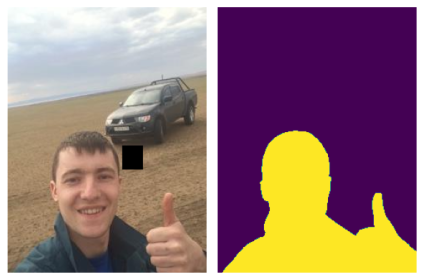

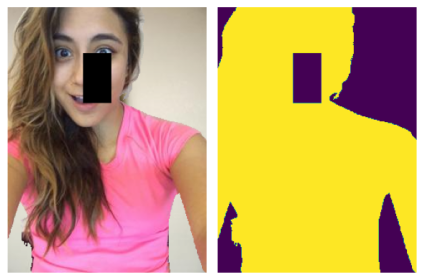

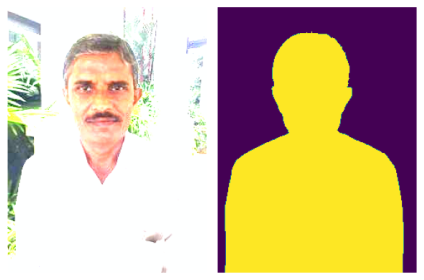

In [8]:
show_idx_image(train_dataset, 10)
show_idx_image(train_dataset, 11)
show_idx_image(train_dataset, 12)

## `Загрузчики`

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры `DataLoader`. При `num_workers`$\;> 1$, батчи готовятся (загружаются картинки, обрабатываются и так далее) сразу в нескольких фоновых процессах. С помощью параметра `shuffle` можно подавать картинки на обучение в случайном порядке.

Обычно, скорость обработки данных на GPU превышает скорость загрузки данных в одном процессе, поэтому типичное значение для `num_workers`$\approx 3\text{-}10$. 

Учтите, что на некоторых системах в Jupyter Notebook при `num_workers`$>0$ `DataLoader` перестаёт работать. В таком случае установите это значение в $0$.

In [9]:
test_data_loader = DataLoader(test_dataset, batch_size=8, num_workers=0)
train_data_loader = DataLoader(train_dataset, batch_size=8, num_workers=0, shuffle=True)

## `DiceLoss (1 балл)`

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через `torch.nn.Module`. В ячейке ниже вам предлагается реализовать функцию потерь `dice` (аналог меры Жаккарда).

Результат **Dice Loss** определим как:

$$
\text{Dice Coefficient} = 2\frac{|A \cap B| }{|A| + |B|} \leadsto \text{Dice Loss} = 1 - \frac{2\sum\limits_{i, j}a_{ij}b_{ij}}{\sum\limits_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — истинная разметка для пикселя изображения.

In [10]:
class DiceLoss(torch.nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        true_labels = true_labels.to(torch.long)

        if self.with_logits:
            logits = torch.sigmoid(logits)

        
        dice_loss = 1 - 2 * torch.sum(logits * true_labels, dim=(1, 2))/torch.sum(logits + true_labels + self.eps, dim=(1, 2))
        
        if self.reduction == 'sum':
            loss_value = dice_loss.sum()
        elif self.reduction == 'mean':
            loss_value = dice_loss.mean()
        elif self.reduction is None:
            loss_value = dice_loss
            
        return loss_value

Проверка реализации:

In [11]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## `U-Net (3 балла)`

Для решения задачи сегментации будем использовать [U-Net](https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного `VGG13`.

Концептуальная схема представлена на диаграмме ниже:

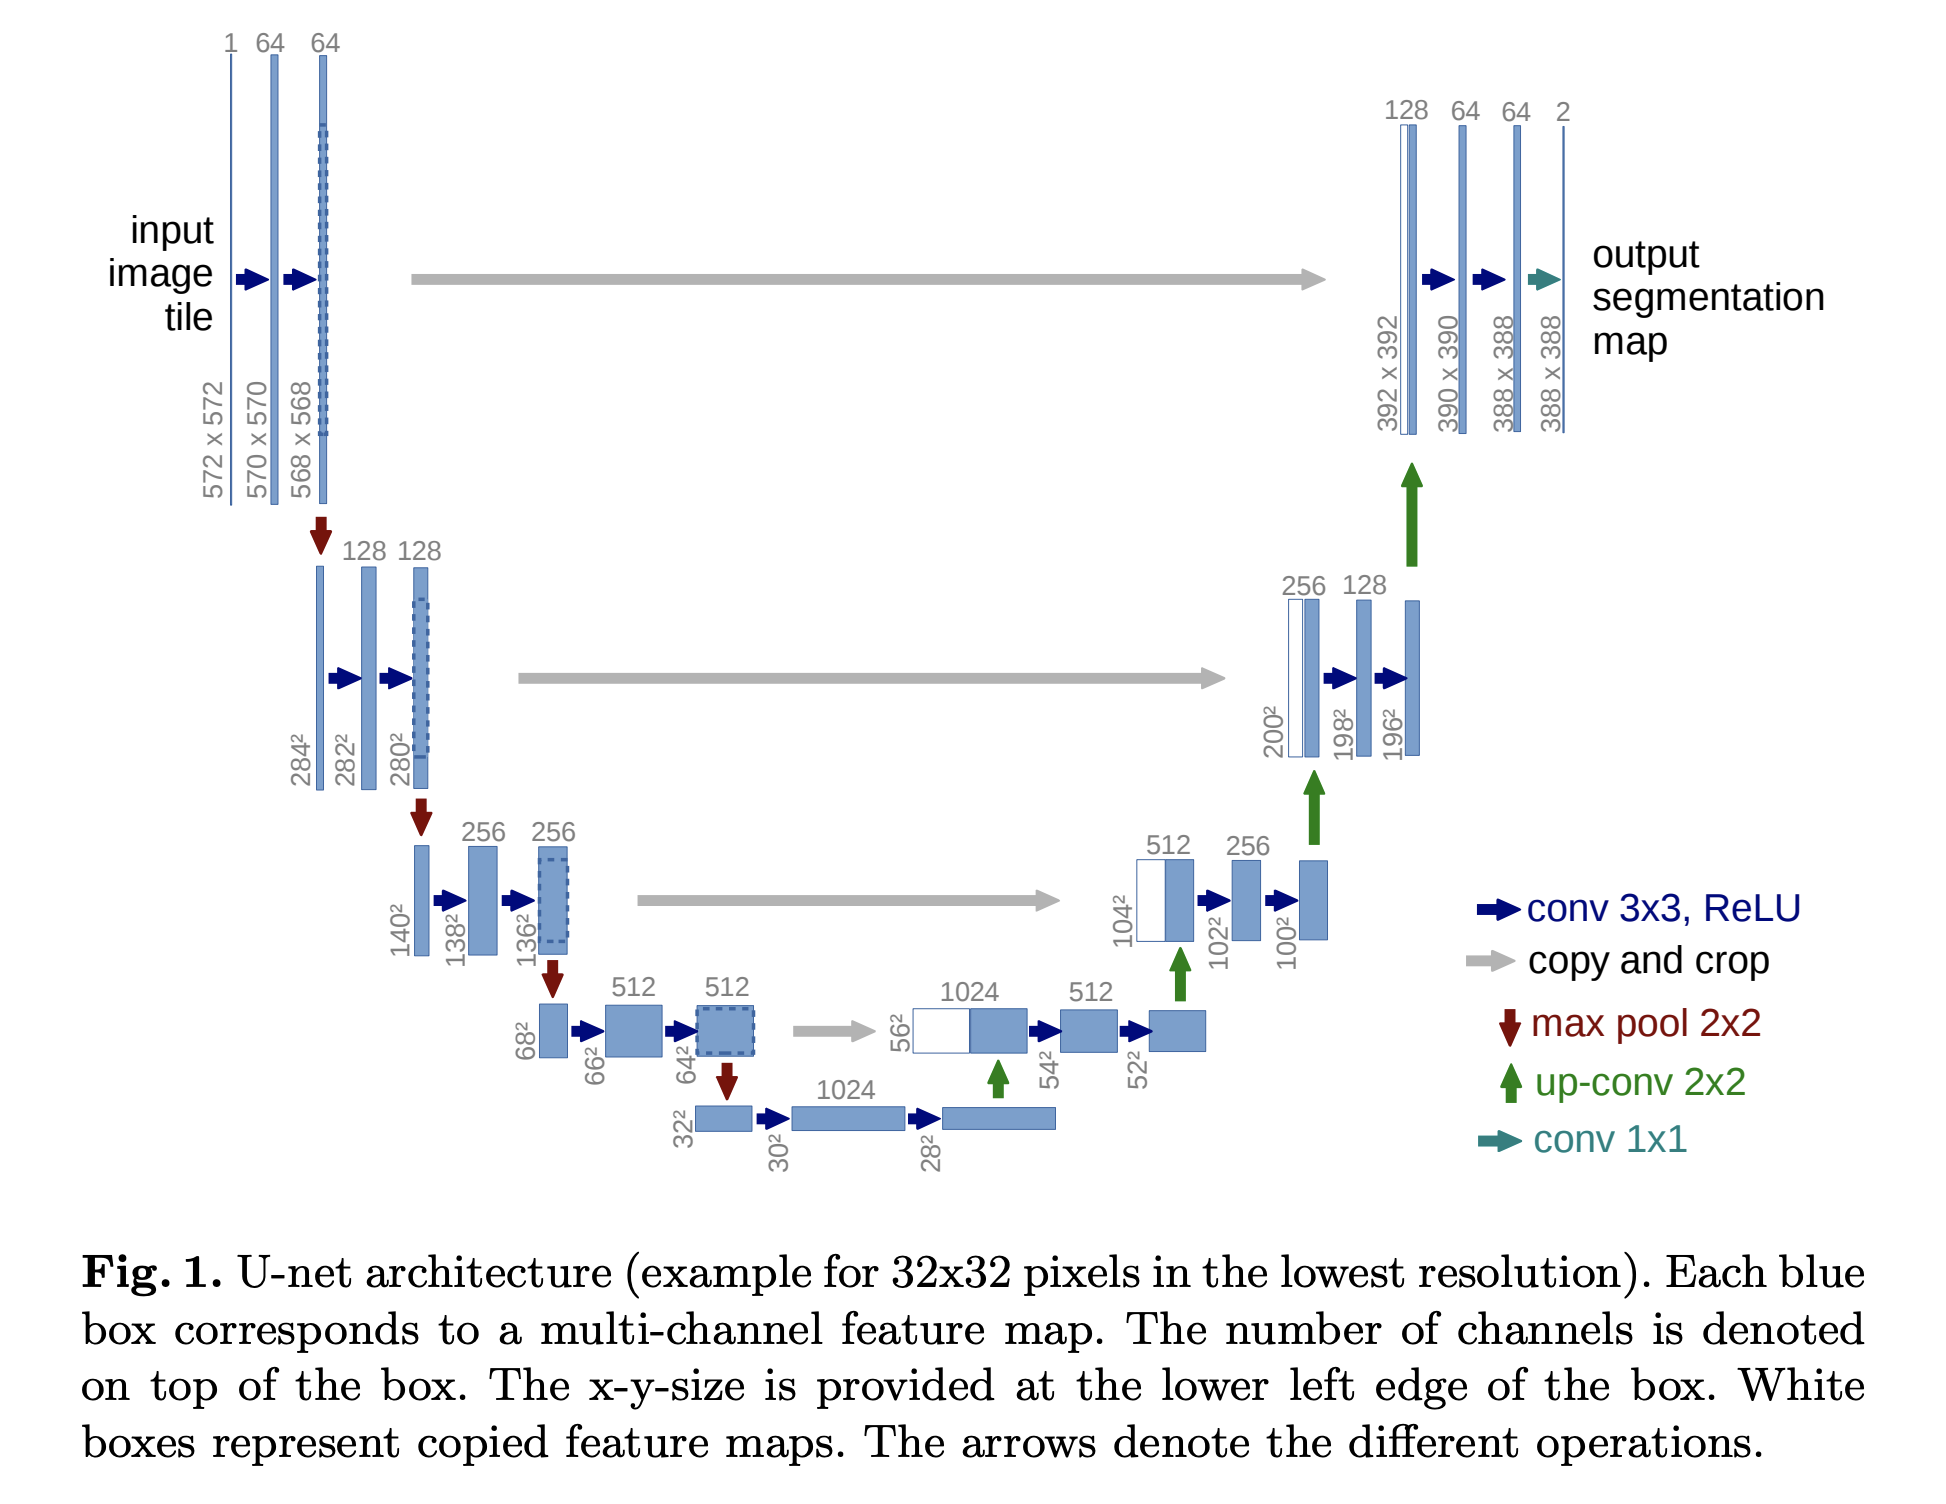

Заметим, что блоки VGG13 имеют следующий вид:
```python
    (0): Conv2d(...)
    (1): ReLU(...)
    (2): Conv2d(...)
    (3): ReLU(...)
    (4): MaxPool2d(...)
```

Для удобства, уберём слои `MaxPool2d` из блоков энкодера и будем применять pooling отдельно. Возможно, вам будет полезно вывести архитектуру модели `VGG` и изучить параметры слоев pooling.

При реализации `Decoder` вам пригодится интерполяция, для этого можно использовать `torch.nn.functional.interpolate` с `mode=nearest`. 

Реализуйте архитектуру данной сети.

#### `Encoder`

In [12]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, weights=VGG13_Weights.DEFAULT):
        super().__init__()
        self.num_blocks = num_blocks
        
        # Будем использовать предобученную VGG13 в качестве backbone
        feature_extractor = vgg13(weights=weights).features

        def replace_relu(module):
            for name, layer in module.named_children():
                if isinstance(layer, torch.nn.ReLU) and layer.inplace:
                    setattr(module, name, torch.nn.ReLU(inplace=False))
                else:
                    replace_relu(layer)

        replace_relu(feature_extractor) 
        
        # Каждый блок энкодера U-Net — это блок VGG13 без MaxPool2d
        self.blocks = torch.nn.ModuleList()
        for idx in range(self.num_blocks):
            # Возьмите нужные слои из `feature_extractor` для очередного U-Net блока
            # Объедините их с помощью `torch.nn.Sequential`
            self.blocks.append(
                torch.nn.Sequential(
                    feature_extractor[idx*5],
                    feature_extractor[idx*5 + 1],
                    feature_extractor[idx*5 + 2],
                    feature_extractor[idx*5 + 3]
                )
            )
        
    def forward(self, x):
        activations = []
        for idx, block in enumerate(self.blocks):
            # Примените очередной блок U-Net
            x = block(x)

            # Сохраните активации для передачи их в декодер
            activations.append(x)

            # При необходимости примените max-pool
            # Можно использовать `torch.functional.F.max_pool2d`
            if idx != self.num_blocks-1:
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
        return activations

In [13]:
assert sum((param.numel() for param in VGG13Encoder(num_blocks=1).parameters())) == 38720
assert sum((param.numel() for param in VGG13Encoder(num_blocks=2).parameters())) == 260160
assert sum((param.numel() for param in VGG13Encoder(num_blocks=3).parameters())) == 1145408

x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)
out = VGG13Encoder(num_blocks=3)(x)

assert len(out) == 3
npt.assert_almost_equal(torch.linalg.norm(out[0]).item(), 902.218, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[1]).item(), 571.030, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[2]).item(), 648.068, decimal=3)

#### `Decoder`

In [14]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = torch.nn.ReLU()
        
    def forward(self, down, left):
        # Upsample x2 и свёртка
        x = self.upconv(down)

        if x.shape[2:] != left.shape[2:]:
            x = torch.nn.functional.interpolate(x, size=left.shape[2:], mode='nearest')
            
        # Конкатенация выхода энкодера и предыдущего блока декодера
        x = torch.cat([left, x], dim=1)
        
        # Две свёртки с ReLu
        x = self.conv1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.relu(x)

        return x

In [15]:
class Decoder(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        self.blocks = torch.nn.ModuleList()
        for idx in range(num_blocks):
            self.blocks.insert(0, DecoderBlock(num_filters * 2 ** idx))

    def forward(self, acts):
        up = acts[-1]
        for block, left in zip(self.blocks, acts[-2::-1]):
            up = block(up, left)
        return up

#### `U-Net`

In [16]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_blocks=4):
        super().__init__()
        
        self.encoder = VGG13Encoder(num_blocks)
        
        self.decoder = Decoder(64, num_blocks-1)
        
        # Свёртка 1x1 для попиксельной агрегации каналов
        
        self.final = torch.nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x = self.encoder(x)

        x = self.decoder(x)

        x = self.final(x)
        
        return x

In [17]:
model = UNet(num_classes=1, num_blocks=3)
x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)

assert sum((param.numel() for param in model.parameters())) == 2067649
assert list(model(x).shape) == [1, 1, 320, 240]
model

UNet(
  (encoder): VGG13Encoder(
    (blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0): DecoderBlock(
        (upconv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1

### `Оценивание качества сети`


Обычно, оптимизируемый функционал сложно интерпретировать, а так же в разных экспериментах могут использоваться разные функции потерь. Поэтому необходимо замерять и отслеживать независимую метрику качества. Предлагается использовать **IoU (Intersection over Union)** — один из стандартных вариантов для задачи сегментации:
$$
\text{IoU} = \frac{|A \cap B|}{|A \cup B|} = \frac{\sum\limits_{ij}a_{ij}b_{ij}}{\sum\limits_{ij}a_{ij} + b_{ij} - a_{ij}b_{ij}}
$$

Учтите, что знаменатель может быть равен нулю, например, если маска нулевая. Такие объекты можно не учитывать при агрегации и пропускать, так как в ином случае подсчет метрики на всем батче будет NaN. В pytorch есть встроенные для этого функции с префиксом nan.


In [18]:
class IoUScore(torch.nn.Module):
    def __init__(self, threshold, reduction=None):
        """
        Arguments
        ---------
        threshold : float
            threshold for logits binarization
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        
        self.threshold = threshold
        self.reduction = reduction
        
    @torch.no_grad()
    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        logits = (logits > self.threshold).float()
        
        iou = torch.sum(logits * true_labels, dim=(1, 2))/ (torch.sum(logits + true_labels - logits * true_labels, dim=(1, 2)))
        
        if self.reduction == 'sum':
            score = torch.nansum(iou)
        elif self.reduction == 'mean':
            score = torch.nanmean(iou)
        else:
            score = iou
            
        return score

In [19]:
logits = torch.tensor([
    [
        [0.3089,  0.4311, -0.9711],
        [0.9030,  1.0325, -0.7607],
        [0.9648, -0.5528, -1.1010]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ]
])
true_labels = torch.tensor([
    [
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]
    ], [
        [1., 1., 1.],
        [1., 0., 1.],
        [1., 0., 0.]
    ], [
        [1., 1., 1.],
        [0., 1., 1.],
        [1., 1., 1.]
    ]
])

scores = IoUScore(0.0)(logits, true_labels)
npt.assert_almost_equal(scores.numpy(), np.array([0.3333, 1.0000, 0.5556]), decimal=4)

score = IoUScore(0.0, reduction='sum')(logits, true_labels)
npt.assert_almost_equal(score.item(), 1.8889, decimal=4)

score = IoUScore(0.0, reduction='mean')(logits, true_labels)
npt.assert_almost_equal(score.item(), 0.6296, decimal=4)

### `Логирование`

При реализации цикла обучения необходимо сохранять метрики $1\text{-}9$ с использованием модуля [torch.utils.tensorboard](https://pytorch.org/docs/stable/tensorboard.html) или с помощью модуля [wandb](https://docs.wandb.ai/tutorials/) вам предлагается самим выбрать более удобный для вас модуль.

Для отслеживания процесса обучения обычно требуется сохранять информацию разных его аспектах.

Для полного контроля над процессом обучения обычно требуется сохранять информацию о разных статистиках. Самыми очевидными являются:
1. Значение функции потерь (лосса) на обучающей и тестовой выборках
2. Метики качества, например, **Dice Coefficient** и **IoU (Intersection over Union)** на обучающей и тестовой выборках

Однако, суррогатные метрики могут не отражать реального качества. Поэтому для моделей, которые выдают визуализируемый результат, обычно логируют предсказания для некоторых объектов выборки. В задаче сегментации естественным вариантом является логирование четвёрки: исходное изображение, истинная маска, маска вероятностей истинного класса, бинаризованная маска. 

*Замечание:* лосс и качество на обучающей выборке обычно логируют не только в конце каждой эпохи, но и по отдельным батчам на каждой итерации.

3. Чтобы отслеживать динамику обучения необходимо зафиксировать небольшой набор объектов обучающей и тестовой выборок и после каждой эпохи обучения логировать указанные четыре картинки для каждого объекта.

*Замечание:* можно логировать четвёрки изображений независимо, однако, удобнее объединить их на одной фигуре [реализация через Tensorboard](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_figure), [реализация через Wandb](https://docs.wandb.ai/guides/track/log/plots/#matplotlib-and-plotly-plots) (лучше делать через fig и Image). Дополнительный плюс — возможность подписать значения метрик для этого объекта в заголовке изображения или добавить colorbar для более простой интерпретации предсказанной маски.

Для удобной категоризации экспериментов обычно в начале обучения сохраняют:

4. Гиперпараметры модели [реализация через Tensorboard](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_hparams), [реализация через Wandb](https://docs.wandb.ai/guides/track/config/)
5. Структуру модели [реализация через Tensorboard](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_graph), **про реализацию wandb ниже**

Для исследования технических особенностей обучения полезно логировать следующие статистики:

6. Распределение весов, активаций, градиентов [реализация через Tensorboard](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_histogram), [реализация через Wandb](https://docs.wandb.ai/ref/python/data-types/histogram/). Сохранять гистограммы каждого параметра после каждой итерации может быть вычислительно неэффективно, поэтому обычно сохраняют распределения весов для каждого отдельного слоя нейронной сети после каждой эпохи. 
7. Норма весов и норма градиента на каждой итерации

Наконец, после каждой эпохи можно визуализировать промежуточные представления входных данных:

8. Активации после каждого слоя/блока, как изображения
9. Градиенты функции потерь по активациям для некоторых объектов обучающей выборки, как изображения

*Замечание:* для реализации пунктов 8, 9 менять код модели не требуется. Используйте хуки: [register_full_backward_hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook) (данный хук не работает с inplace операциями, например, с `torch.nn.ReLU(inplace=True)`. Или не используйте inplace операции, или используйте [`Tensor.register_hook`](https://github.com/pytorch/pytorch/issues/61519)), [register_forward_hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_forward_hook).

Файлы с логами, а также чекпоинты весов модели после итерации с наилучшим валидационным качеством (смотрите [torch.save](https://pytorch.org/docs/stable/generated/torch.save.html) и [torch.nn.Module.state_dict](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html)) для **ВСЕХ** проведённых экспериментов (за исключением упавших, недосчитанных и так далее) необходимо сдать в anytask.

#### `Некоторые советы по wandb`

- При логировании всегда указывайте параметр step, который должен не уменьшаться.

- При логировании изображений лучше их нормировать в диапазон [0, 1] как в функции `show_idx_image` выше. Для логирования предсказаний маски, лучше использовать вероятности. При неправильном диапозоне изображения могут отображаться неверно!

- Вместо логирования изображений, лучше логировать `matplotlib` графики и соответсвующие им `figure`. Кроме того, лучше закрывать все открытые графики, чтобы не перегружать ноутбук. Пример кода:


```python
fig, ax = plt.subplots(...)
...
wandb.log({key: wandb.Image(fig)}, step=global_step)
plt.close('all')
```

- Функционал построение bins в `wandb.Histogram` ограничен, можете посмотреть в сторону аргумента `np_histogram`.

- Wandb не имеет широкого функционала для логирования структуры модели. Есть способ через wandb.watch(net, log_graph=True), но получаемый результаты сильно отличаются от возможностей `tensorboard`. К счастью, `wandb` умеет синхронизировать логи с `Tensorboard` поэтому можно использовать следующую логику:


```python
wandb.init(
    project=project_name, 
    name=run_name, 
    config=config, 
    sync_tensorboard=True        # Синхронизация с tensorboard
)

writer = SummaryWriter(run_name) # Создание логера tensorboard

# Логирование графа модели
writer.add_graph(net, input_x)
writer.close()

train_loop(...)
wandb.finish()
```

- `wandb` по умолчанию сохраняет все логи локально и на сайте в вашем личном хранилище. В случае перезагрузки `Google Colab` локальные файлы не сохраняются! Кроме того, скачивание файлов не через GoogleDisk достаточно продолжительное (в районе 20-30 минут).

- В `wandb` можно легко сохранять код и указать директорию, так вы никогда не забудете какой именно код получает результаты логов.

```python
wandb.init(..., settings=wandb.Settings(code_dir="."))
```

Кроме того, можно сохранить отдельные файлы:

```python
wandb.init(..., save_code=True)
wandb.run.log_code(
    "./", 
    include_fn=lambda path: condition(path)
)
```

- В `wandb` есть функция для автоматического логирования весов и градиентов модели `wandb.watch()`, но функционал слишком ограничен и накладывает слишком много накладных расходов. **Лучше писать руками!**

#### `Некоторые советы по tensorboard`

- Функционал и возможности `tensorboard` шире (работа с 3D, продвинутые визуализации).

- `tensorboard` сохраняет логи только локально, то есть после закрытия `Google Colab` ничего не сохранится. В реальных проектах это является сильной стороной, так как гарантирует безопасность и конфиденциальность.

- Для визуализации логов достаточно запустить в ноутбуке или в терминале соответсвующее расширение, однако в случае `Google Colab` для этого приходится прокидывать порты, [подробнее тут](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).

- `tensorboard` меньше лагает и более легковесный.


### `Некоторые советы по логированию`

- Вы можете выбрать либо `wandb`, либо `tensorboard`.

- В реальных проектах лучше добавить логирование кода с целью сохранения и воспроизводимости результатов.

- Называйте запуски осмысленно, чтобы по названию можно было понять смысл запуска и варьеруемые параметры.


### `Эксперименты`

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке. 

Сначала при обучении используйте только кросс-энтропию (`torch.nn.BCEWithLogitsLoss` будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации:
1. Только кросс-энтропия
2. Только dice loss
3. Сумма двух лоссов с весами (попробуйте $3\text{-} 4$ разных соотношения)

**Для всех экспериментов отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.**

In [20]:
import wandb

In [21]:
# вход в wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb.login(key=user_secrets.get_secret("WANDB_API_KEY"))

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: s02220164 (s02220164-m-v-lomonosovmoscow-state-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [22]:
def set_global_seed(seed: int) -> None:
    """Set global seed for reproducibility.
    :param int seed: Seed to be set
    """
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_global_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [23]:
@torch.no_grad()
def evaluate(net, valid_dataloader, loss_fn, device):
    iou_score = IoUScore(0.5, reduction="mean")
    dice_score = DiceLoss(reduction='mean')
    
    net.eval()
    loss, iou, dice = 0, 0, 0
    count = 0
    
    for X_batch, y_true in valid_dataloader:
        X_batch = X_batch.to(device)
        y_true = y_true.to(device)

        out = net(X_batch)
        
        bs = out.shape[0]
        loss += loss_fn(out, y_true).item() * bs
        iou += iou_score(out, y_true).item() * bs
        dice += dice_score(out, y_true).item() * bs
        count += bs
        
    return loss / count, iou / count, dice / count

@torch.no_grad()
def log_gradients(model, global_step, log_norm=True, log_hist=True):
    for tag, value in model.named_parameters():
        g = value.grad
        if g is None:
            continue
        
        if log_hist:
            wandb.log({f"grad/{tag}": wandb.Histogram(g.cpu())}, global_step)
        
        if log_norm:
            wandb.log({f"grad_norm/{tag}": torch.norm(g.cpu())}, global_step)

@torch.no_grad()
def log_weights(model, global_step, log_norm=True, log_hist=True):
    for tag, value in model.named_parameters():
        g = value.grad
        if g is None:
            continue
        
        if log_hist:
            wandb.log({f"weight/{tag}": wandb.Histogram(value.cpu())}, global_step)
        
        if log_norm:
            wandb.log({f"weight_norm/{tag}": torch.norm(value.cpu())}, global_step)


@torch.no_grad()
def log_images(model, global_step, tag, images, device):
    fig, ax = plt.subplots(len(images), 4, figsize=(8*len(images), 20))
    model.eval()
    
    for idx, batch in enumerate(images):
        img, y_true = batch
        img = img.unsqueeze(0)

        img = img.to(device)
        y_true = y_true.to(device)

        out = model(img)
        
        binary_img = (out > 0.5).float()

        y_true = y_true.cpu().squeeze(0).numpy()
        img = img.cpu().squeeze(0).permute(1, 2, 0).numpy()
        img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        out = out.cpu().squeeze(0).permute(1, 2, 0).numpy()
        binary_img = binary_img.cpu().squeeze(0).permute(1, 2, 0).numpy()
        
        ax[idx, 0].imshow(img)
        ax[idx, 0].set_xlabel("Ориг. изображение")
        ax[idx, 1].imshow(y_true)
        ax[idx, 1].set_xlabel("Ориг. маска")
        ax[idx, 2].imshow(out)
        ax[idx, 2].set_xlabel("Предсказ. вероятности")
        ax[idx, 3].imshow(binary_img)
        ax[idx, 3].set_xlabel("Предсказ. маска")

        for i in range(4):
            ax[idx, i].set_axis_off()
    
    wandb.log({f"{tag}/fix_images": wandb.Image(fig)}, step=global_step)
    plt.close('all')

In [24]:
def create_log_forward_hook(global_step):
    def log_forward_hook(module, _input, output):
        for i in range(output.size(1)):
            activation = output[0, i].detach().cpu()
            wandb.log({f"activation/{module.__class__.__name__}_{i}": wandb.Image(activation)}, step=global_step)
    return log_forward_hook

def create_log_backward_hook(global_step):
    def log_backward_hook(module, grad_input, grad_output):
        for i in range(grad_output[0].size(1)):
            grad = grad_output[0][0, i].detach().cpu()
            wandb.log({f"gradient/{module.__class__.__name__}_{i}": wandb.Image(grad)}, step=global_step)
    return log_backward_hook

def register_hooks(model, global_step):
    hook_handles = []
    for layer in model.children():
        if isinstance(layer, (torch.nn.ModuleList, VGG13Encoder, Decoder, DecoderBlock)):
            hook_handles.extend(register_hooks(layer, global_step))
        elif isinstance(layer, torch.nn.Sequential):
            sublayer = list(model.children())[-1]
            forward_handle = sublayer.register_forward_hook(create_log_forward_hook(global_step))
            backward_handle = sublayer.register_backward_hook(create_log_backward_hook(global_step))
            hook_handles.append((forward_handle, backward_handle))
        elif isinstance(layer, (torch.nn.ReLU, torch.nn.Conv2d)):
            forward_handle = layer.register_forward_hook(create_log_forward_hook(global_step))
            backward_handle = layer.register_backward_hook(create_log_backward_hook(global_step))
            hook_handles.append((forward_handle, backward_handle))
        else:
            continue

    return hook_handles

In [25]:
from tqdm import tqdm

def train_model(config, net, optimizer, loss_fn, train_dataloader, valid_dataloader,
                device, train_images, val_images):
    
    wandb.init(
        project="cnn_prac_mmp_2025", 
        name=config['name'], 
        config=config
    )

    global_step = 0
    
    wandb.log({"model_structure": str(net)}, step=global_step)
    
            
    net = net.to(device)
    
    best_iou = 0
    os.makedirs(config['checkpoint_dir'], exist_ok=True)
    
    iou_score = IoUScore(0.5, reduction='mean')
    dice_score = DiceLoss(reduction='mean')

    train_b_images = torch.stack([image for image, _ in train_images]).to(device) 
    train_b_masks = torch.stack([mask for _, mask in train_images]).to(device)
    
    epoch_num = config['epoch_num']
    for epoch in tqdm(range(epoch_num)):
        net.train()
        
        for X_batch, y_true in train_dataloader:
            optimizer.zero_grad()
            
            X_batch = X_batch.to(device)
            y_true = y_true.to(device)
            
            out = net(X_batch)
            
            loss = loss_fn(out, y_true)
            loss.backward()
            
            optimizer.step()
            
            log_gradients(net, global_step, log_hist=False)
            log_weights(net, global_step, log_hist=False)

            iou = iou_score(out, y_true)
            dice = dice_score(out, y_true)
            
            wandb.log({"train/loss": loss.item(), "train/iou": iou.item(), "train/dice": dice.item()}, step=global_step)
            
            global_step += 1
        
        loss, iou, dice = evaluate(
            net              = net, 
            valid_dataloader = valid_dataloader, 
            loss_fn          = loss_fn, 
            device           = device
        )
        wandb.log({"eval/loss": loss, "eval/iou": iou, "eval/dice": dice}, step=global_step)
    
        log_gradients(net, global_step, log_norm=False)
        log_weights(net, global_step, log_norm=False)

        # логирование фикс. обуч. набора (img, mask, logits, pred_mask)
        log_images(net, global_step, "train", train_images, device)
        
        # логирование фикс. валид. набора (img, mask, logits, pred_mask)
        log_images(net, global_step, "eval", val_images, device)
        
        if iou > best_iou:
            best_iou = iou
            
            torch.save({
                'epoch': epoch,
                'iter': global_step,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'metric': iou
                }, os.path.join(config['checkpoint_dir'], config['checkpoint_name']))

        # логирование активаций и градиентов в виде изображений
        hook_handles = register_hooks(net, global_step)

        train_b_images = torch.stack([image for image, _ in train_images]).to(device) 
        train_b_masks = torch.stack([mask for _, mask in train_images]).to(device)
        
        out = net(train_b_images)
        loss = loss_fn(out, train_b_masks)
        loss.backward()
        
        for forward_hook, backward_hook in hook_handles:
            forward_hook.remove()
            backward_hook.remove()

        net.zero_grad()
        
    wandb.finish()

In [26]:
train_images = [train_dataset[0], train_dataset[1]]
val_images = [test_dataset[0], test_dataset[1]]

test_data_loader = DataLoader(test_dataset,
                              batch_size=8,
                              num_workers=4)
train_data_loader = DataLoader(train_dataset,
                               batch_size=32,
                               num_workers=4,
                               shuffle=True)

In [27]:
config = {
    'seed'           : 42, 
    'lr'             : 1e-4, 
    'epoch_num'      : 10,
    'name'           : 'UNet CE=1.0 DICE=0.0',
    'checkpoint_dir' : './checkpoints/ce', 
    'checkpoint_name': 'UNet_CE.pth'
}

loss_fn = torch.nn.BCEWithLogitsLoss()
net = UNet()
net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=config['lr'])

train_model(
    config           = config, 
    net              = net, 
    optimizer        = optimizer, 
    loss_fn          = loss_fn, 
    train_dataloader = train_data_loader, 
    valid_dataloader = test_data_loader, 
    device           = device,
    train_images     = train_images,
    val_images       = val_images
)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
100%|██████████| 10/10 [17:36<00:00, 105.64s/it]


eval/dice,█▅▆▅▃▃▂▂▁▂
eval/iou,▁▄▄▅▆▇▇██▇
eval/loss,█▅▅▃▃▂▁▂▁▂
grad_norm/decoder.blocks.0.conv1.bias,▁▁▂▅▃▂▂▃▃▂▁▃▂▂▂▂▃▂▂▁▃▃▃▂▅▆▃▁▄▂▃▄▅▂▂▂▄▇▅█
grad_norm/decoder.blocks.0.conv1.weight,▁▂▇▂▇▂▂▃▂▂▂▄▂▂▂▃▅▅▃▂▂▄▄▆▅▂▄█▃▄▃▂▂▂▂▂▃▃▃▂
grad_norm/decoder.blocks.0.conv2.bias,▃▁▁▂▃▃▃▂▂▃▄▃▂▂▃▂▃▃▅▃▃█▇▇▇▁▅▃▂▂█▇▄▆▇▅▃▂▃▅
grad_norm/decoder.blocks.0.conv2.weight,▁▁▂▄▃▂▃▃▂▂▂▂▂▁▄▃▃▃▂▃▅▃▆▂█▃▃▃▄▆▆▄▄▅▅▂▃▄▃█
grad_norm/decoder.blocks.0.upconv.bias,▁▁▁▁▂▁▅▂▂▃▄▂▂▃▃▃▇▄▁▇▇▄▃▇▁▂▁▂▁█▂▆▄▂▂▄▆▃▃▇
grad_norm/decoder.blocks.0.upconv.weight,▁▁▂▃█▂▁▁▂▂▁▂▂▄▅▃▂▃▁▅▇▂▂▁▂▂▄▄▇▂▅█▂▁▃▅▃▂▃▆
grad_norm/decoder.blocks.1.conv1.bias,▁▂▃▅▁▃▃▂▂▂▃▁▂▂▂▁▂▃▃▁▃▃▅▂▃▄▃▃▅▇█▃▄▃▅▂▄▄▂▆
grad_norm/decoder.blocks.1.conv1.weight,▆▃▂█▃▃▅▂▂▁▁▁▃▁▁▃▂▁▄▂▃▂▄▄▂▄▃▁▂▆▄▄▂▂▂▄▂▂▂▄


In [28]:
# только DiceLoss
config = {
    'seed'           : 42, 
    'lr'             : 1e-4, 
    'epoch_num'      : 10,
    'name'           : 'UNet CE=0.0 DICE=1.0',
    'checkpoint_dir' : './checkpoints/dice', 
    'checkpoint_name': 'UNet_DICE.pth'
}

loss_fn = DiceLoss(reduction='mean')
net = UNet()
net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=config['lr'])

train_model(
    config           = config, 
    net              = net, 
    optimizer        = optimizer, 
    loss_fn          = loss_fn, 
    train_dataloader = train_data_loader, 
    valid_dataloader = test_data_loader, 
    device           = device,
    train_images     = train_images,
    val_images       = val_images
)

100%|██████████| 10/10 [16:19<00:00, 97.99s/it]


eval/dice,▁▁▁▁▁▁▁▁▁▁
eval/iou,▁▁▁▁▁▁▁▁▁▁
eval/loss,▁▁▁▁▁▁▁▁▁▁
grad_norm/decoder.blocks.0.conv1.bias,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_norm/decoder.blocks.0.conv1.weight,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_norm/decoder.blocks.0.conv2.bias,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_norm/decoder.blocks.0.conv2.weight,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_norm/decoder.blocks.0.upconv.bias,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_norm/decoder.blocks.0.upconv.weight,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_norm/decoder.blocks.1.conv1.bias,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_norm/decoder.blocks.1.conv1.weight,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [29]:
class DiceCELoss(torch.nn.Module):
    def __init__(self, alpha, beta):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.dice = DiceLoss(reduction='mean')
        self.ce = torch.nn.BCEWithLogitsLoss()

    def forward(self, logits, true_labels):
        loss_value = self.alpha * self.dice(logits, true_labels) + self.beta * self.ce(logits, true_labels)
        return loss_value

In [30]:
pairs_coeffs = [(0.5, 0.5), (0.7, 0.3), (0.3, 0.7), (0.9, 0.1) ]

In [31]:
for idx, pair in enumerate(pairs_coeffs):
    alpha, beta = pair
    config = {
        'seed'           : 42, 
        'lr'             : 1e-4, 
        'epoch_num'      : 10,
        'name'           : f'UNet CE={alpha} DICE={beta}',
        'checkpoint_dir' : f'./checkpoints/dice_ce{str(idx)}', 
        'checkpoint_name': f'UNet_DICE_CE{str(idx)}.pth'
    }
    
    loss_fn = DiceCELoss(alpha, beta)
    net = UNet()
    net.to(device)
    
    optimizer = torch.optim.Adam(net.parameters(), lr=config['lr'])
    
    train_model(
        config           = config, 
        net              = net, 
        optimizer        = optimizer, 
        loss_fn          = loss_fn, 
        train_dataloader = train_data_loader, 
        valid_dataloader = test_data_loader, 
        device           = device,
        train_images     = train_images,
        val_images       = val_images
    )


100%|██████████| 10/10 [17:33<00:00, 105.37s/it]


eval/dice,█▃▄▃▂▂▁▁▁▁
eval/iou,▁▄▅▆▇▆▇▇██
eval/loss,█▆▄▃▂▃▂▁▁▁
grad_norm/decoder.blocks.0.conv1.bias,▁▂▁▁▂▂▃▂▂▂▄▃▅▄▄▁▃▆▂▃▂▅▅▇▂▄▂██▂▂▄▄▃▄▃▃▅▃▆
grad_norm/decoder.blocks.0.conv1.weight,▁▆▄▅▃▃▄▄▂▅▃▅█▄▄▃▂▃▄▄▄▅▅█▅▇▆▄▇▇▅▄▇▆▃█▅▇▄▄
grad_norm/decoder.blocks.0.conv2.bias,▁▂▁▁▂▃▁▂▂▂▅▅▃▃▄▂▁▃▁▃▂▃█▇▅█▄▂▆▃▂▅▅▃▄▃▂▃▃▁
grad_norm/decoder.blocks.0.conv2.weight,▁▁▁▂▂▂▂▂▃▂▂▁▂▂▃▄▂▂▃▂▅▂▂▃█▂▂▂▂▃▃▂▄▂▂▁▂▂▂▂
grad_norm/decoder.blocks.0.upconv.bias,▂▁▃▂▁▂▂▃▄▁▃▃▂▄▃▁▆▃▂▂▂▃▂▁▂▁▇█▂▂▂▁▁▄▃▃▃▇▄▅
grad_norm/decoder.blocks.0.upconv.weight,▁▁▃▂▃▂▂▂▁▂▂▅▄▂▁▂▂▃▄▄▃▅▄▃▄▂▃▅█▂▇▂▂▄▄▂▅▅▂▂
grad_norm/decoder.blocks.1.conv1.bias,▂▂▂▃▃▁▁▁▁▂▁▁▂▂▃▂▃▂▁▁▅▂▂▂▂▂▅▄█▇▄▂▃▅█▅▅▄▂▆
grad_norm/decoder.blocks.1.conv1.weight,▆▃▂▅▄▂█▄▅▄▂▁▄▃▅▇▅▁▄▁▂▃▄▂▆▃▁▃▄▄▂▁▂▄▂▃▃▂▂▂


100%|██████████| 10/10 [17:46<00:00, 106.65s/it]


eval/dice,█▄▃▂▂▂▂▁▁▁
eval/iou,▁▄▆▆▇▇▇▇██
eval/loss,█▄▃▃▂▂▂▁▁▁
grad_norm/decoder.blocks.0.conv1.bias,▁▁▂▂▂▃▂▂▂▂▂▂▁▁▁▂▂▂▂▃▃▅▂▃▅▁▁▆▃▅▁▅▃▁▄█▂▄▄▂
grad_norm/decoder.blocks.0.conv1.weight,▁▁▇▄▃▄▄▃▃▃▂▃▂▂▂▂▅▄▅█▇▆▆▆▃▄▆▃▃▅▃▄▃█▄▃▅▃▄▃
grad_norm/decoder.blocks.0.conv2.bias,▁▁▁▁▂▂▂▂▁▂▁▃▂▄▄▁▃▂▂▂▂▅▂▂▇▄▂▃▄█▅▅▂▁▃▆▃▁▃▂
grad_norm/decoder.blocks.0.conv2.weight,▁▂▁▂▁▇▃▄▃▃▃▂▂▂▃▂▃▃▃▂▂██▇▅▃▃▂▃▂▃▂▄▅▃▁▃▃▃▂
grad_norm/decoder.blocks.0.upconv.bias,▁▂▁▁▁▁▂▁▂▂▅▇▂▁▂▃▄▄▃▆▂▄▄▃▃█▇▆▄▅▃▄▁▃▃▃▄▂▃▂
grad_norm/decoder.blocks.0.upconv.weight,▁▁▃▆▆▃▁▁▂▁▇▅▅▄▅▂▅▃▆█▆▃▄▂▅▃█▇▃▄▂▂▂▃▂▂▃▇▂▄
grad_norm/decoder.blocks.1.conv1.bias,▁▁▂▁▃▂▃▂▁▂▁▁▂▂▁▄▃▁▁▂▂▂▁▂▃▂▄▁▁▂▁▇▃▂▄█▃▄▄▁
grad_norm/decoder.blocks.1.conv1.weight,▁▂▁▄▂▃▂▂█▂▂▁▁▁▁▁▂▂▁▂▃▄▁▄▁▁▂▁▂▁▂▃▃▂▁▁▂▃▂▂


100%|██████████| 10/10 [18:33<00:00, 111.32s/it]


eval/dice,█▄▃▅▃▂▁▁▁▁
eval/iou,▁▃▄▄▆▆██▇█
eval/loss,█▅▄▄▂▄▁▂▂▁
grad_norm/decoder.blocks.0.conv1.bias,▁▁▂▅▂▂▂▂▃▃▂▂▂▅▅▂▄▃▃▂▆▃▇▄▂▇█▅▂▃▆▄▆▄▂▄▄▅▃▂
grad_norm/decoder.blocks.0.conv1.weight,▃▄▄▂▂▂▂▂▁▃▄▂▃▃▄▆▃▃▃▇█▃▄▃▂▆▆▃▁▄▂▆▂▂▆▄▃▅▃▂
grad_norm/decoder.blocks.0.conv2.bias,▁▂▃▁▂▂▂▁▃▄▂▃▂▁▅▃▂▃▂▂▁▂▄▃▅▅▄▂▂▂▂▂▄█▆▁▃▃▃▃
grad_norm/decoder.blocks.0.conv2.weight,▃▃▄▄▂▂▁▁▇▃▄▃▅▃▄▄▂▂▃▁▄▁▅▇█▁▅▁▁▇▃▄▅█▄▇▅▄▁▆
grad_norm/decoder.blocks.0.upconv.bias,▁▂▁▃▁▄▂▃▃▃▃▂▂▂▆▂▃▆▅▃▄▂▂▄▁▂▅▂▅▃█▆▄▂▄▃▂▃▃▄
grad_norm/decoder.blocks.0.upconv.weight,▁▁▃▂▃▁▁▂▂▃▁▇▇▄▂▂█▃▅▄▄▄▆▆▆▃▃▄▃▂▂▃▂▃▂▃▂▂▂▁
grad_norm/decoder.blocks.1.conv1.bias,▂▇▃▂▁▁▃▂▁▃▃▁▅▆▁▅▃▁▃▄▃▂▆█▅▄▆▅▂▃▅▂▃▃▁▆▄▃▄▃
grad_norm/decoder.blocks.1.conv1.weight,▁▄▂▃▂▂▄▁▃▃▅▂█▁▄▅▁▅▄▂▃▂▁▃▅▂▃▂▂▃▃▃▂▆▂▃▃▂▂▄


100%|██████████| 10/10 [18:48<00:00, 112.87s/it]


eval/dice,█▃▃▂▂▂▂▁▁▁
eval/iou,▁▄▄▆▅▆▆███
eval/loss,█▃▃▂▂▂▂▁▁▁
grad_norm/decoder.blocks.0.conv1.bias,▁▂▂▂▁▁▂▁▁▁▂▁▁▁▁▃▂▅▄▂▂▃▄▄▄▃▄▁▂▂█▂▃▂▆▃▁▂▂▅
grad_norm/decoder.blocks.0.conv1.weight,▂▅▃▄▃▁▃▃▃▁▂▁▁▂▂▄▃▂▄▁▂▂▂▄▃▃▃▃▃▂▄▆▃█▃▂▇▂▅▄
grad_norm/decoder.blocks.0.conv2.bias,▂▂▁▂▁▂▂▂▁▁▁▁▁▁▁▃▂▁▂▂▂▂▄▂▁▃▃▁▂▂▆▂▃▃▂▄▄▂█▂
grad_norm/decoder.blocks.0.conv2.weight,▅▃▅▄▂▂▃▁▅▃▂▂▂▂▄▂▄▄▄▃▂▄▂▂▃▆▅█▄▄▃▇█▃▃▄▄▂▂▃
grad_norm/decoder.blocks.0.upconv.bias,▁▁▁▁▁▃▁▃▃▂▂▁▃▂▇▄▃▃▁▁▄▂▄▄▂▃▇▅▆▃▅▂█▇▃▂▄▃▂▂
grad_norm/decoder.blocks.0.upconv.weight,▁▁▃▅▃▃▂▂▂▁▃▃▃▂▂▃▃▃▅█▄▄▄▇▆▄▄▅▄▃▆▄▄▄▄▃▃▂▃▃
grad_norm/decoder.blocks.1.conv1.bias,▂▅▃▃▂▂▂▁▁▁▁▁▁▁▂▁▂▁▂▂▂▃▁▁▁▂▁▁▅▆▂▃▄█▂▄▃▂▁▃
grad_norm/decoder.blocks.1.conv1.weight,█▇▂▄▂▄▃▂▁▁▄▃▁▁▁▃▆▂▁▂▃▁▁▂▂▂▂▃▂▂▄▂▂▂▂▄▂▁▂▂


**Выводы:** По графикам наблюдается, что UNet, обученная только с помощью DiceLoss, не учится. Это, вероятно, связано с дисбалансом классов и с выбором порогового значения, как 0.5. Далее, наблюдается при использовании суммы лоссов CE и DiceLoss повышение качества обучающей модели, относительно использования только CE. Разные стратегии имеют четкое разделение на каждой эпохе на графиках нормы весов, определенный тренд для всех весов определить не удалось. На графиках нормы градиентов заметна стратегия **CE=0.9 DE=0.1**, как минимальная по весам и дисперсии. Наибольшая дисперсия наблюдается у модели, использующей CE. Лучшее качество по IoU показывает модель с лоссом **CE=0.3 DE=0.7**.

## `LinkNet (2 балла)`

Реализуйте архитектуру [LinkNet](https://arxiv.org/pdf/1707.03718.pdf) с использованием энкодера, основанного на `VGG13`. Архитектура похожа на `Unet`, но вместо конкатенации слоёв используются skip-connections (сложения). Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

*Подсказка:* так как конкатенации слоёв заменили на skip-connections, то ожидается, что число параметров стало меньше.

**Обучите сеть и проведите анализ согласно предыдущему пункту. Сравните LinkNet и U-Net по качеству и скорости работы. Сделайте выводы.**

In [34]:
class LinkDecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = torch.nn.ReLU()
        
    def forward(self, down, left):
        # Upsample x2 и свёртка
        x = self.upconv(down)

        if x.shape[2:] != left.shape[2:]:
            x = torch.nn.functional.interpolate(x, size=left.shape[2:], mode='nearest')
            
        # Конкатенация выхода энкодера и предыдущего блока декодера
        x = left + x
        
        # Две свёртки с ReLu
        x = self.conv1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.relu(x)

        return x

class LinkDecoder(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        self.blocks = torch.nn.ModuleList()
        for idx in range(num_blocks):
            self.blocks.insert(0, LinkDecoderBlock(num_filters * 2 ** idx))

    def forward(self, acts):
        up = acts[-1]
        for block, left in zip(self.blocks, acts[-2::-1]):
            up = block(up, left)
        return up

class LinkNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_blocks=4):
        super().__init__()
        
        self.encoder = VGG13Encoder(num_blocks)
        
        self.decoder = LinkDecoder(64, num_blocks-1)
        
        # Свёртка 1x1 для попиксельной агрегации каналов
        
        self.final = torch.nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x = self.encoder(x)

        x = self.decoder(x)

        x = self.final(x)
        
        return x

def register_hooks(model, global_step):
    hook_handles = []
    for layer in model.children():
        if isinstance(layer, (torch.nn.ModuleList, VGG13Encoder, Decoder, DecoderBlock, LinkDecoder, LinkDecoderBlock)):
            hook_handles.extend(register_hooks(layer, global_step))
        elif isinstance(layer, torch.nn.Sequential):
            sublayer = list(model.children())[-1]
            forward_handle = sublayer.register_forward_hook(create_log_forward_hook(global_step))
            backward_handle = sublayer.register_backward_hook(create_log_backward_hook(global_step))
            hook_handles.append((forward_handle, backward_handle))
        elif isinstance(layer, (torch.nn.ReLU, torch.nn.Conv2d)):
            forward_handle = layer.register_forward_hook(create_log_forward_hook(global_step))
            backward_handle = layer.register_backward_hook(create_log_backward_hook(global_step))
            hook_handles.append((forward_handle, backward_handle))
        else:
            continue

    return hook_handles

In [35]:
# только CrossEntropy
config = {
    'seed'           : 42, 
    'lr'             : 1e-4, 
    'epoch_num'      : 10,
    'name'           : 'LinkNet CE=1.0 DICE=0.0',
    'checkpoint_dir' : './checkpoints/link/ce', 
    'checkpoint_name': 'LinkNet_CE.pth'
}

loss_fn = torch.nn.BCEWithLogitsLoss()
net = LinkNet()
net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=config['lr'])

train_model(
    config           = config, 
    net              = net, 
    optimizer        = optimizer, 
    loss_fn          = loss_fn, 
    train_dataloader = train_data_loader, 
    valid_dataloader = test_data_loader, 
    device           = device,
    train_images     = train_images,
    val_images       = val_images
)

100%|██████████| 10/10 [17:26<00:00, 104.69s/it]


eval/dice,▆█▃▃▄▂▂▁▁▁
eval/iou,▄▁▆▆▆▇████
eval/loss,▆█▄▃▃▂▁▁▁▂
grad_norm/decoder.blocks.0.conv1.bias,▁▂▁▂▁▁▁▁▃▃▃▃▂▂▂▃▂▂▂▃▃▅▅▂▃▄█▂▅▂▂▁▃▅▂▅▄█▃▄
grad_norm/decoder.blocks.0.conv1.weight,▂█▃▃▂▄▅▅▅▁▅▄▆▁▂▁▂▂▁▃▂▃▅▃▆█▃▄▆▃▂▂▂▄▆▃▄▃▃▂
grad_norm/decoder.blocks.0.conv2.bias,▃▂▃▁█▁▂▆▄█▇▃▁▄▄▄▆▃█▄▆▆▂▇▃▇▅▆▃▂▆▂▁▄▇▁▅▂▅▂
grad_norm/decoder.blocks.0.conv2.weight,▁▃▄▁▂▁▂▃▁▅▃▄▂▅▅▂▁▁▂▆█▅▂▇▂▅▁▄▅▂▂▃▂▂▃▂▂█▄▂
grad_norm/decoder.blocks.0.upconv.bias,▁▁▁▂▁▂▃▁▃▃▆▄▃▄▁▄▃▆▂▆▂▃▂▃▄▃▂▅▂█▅▂▂█▅▂▃▃▅▁
grad_norm/decoder.blocks.0.upconv.weight,▁▁▃▁▂▂▂▁▁▁▁▁▂▂▁▃▃▂▃▂▃▂▃▁▂▁▂▂▂▁▁▂▄▂▂▄▂▂▁█
grad_norm/decoder.blocks.1.conv1.bias,▁▂▂▂▃▃▁▁▂▄▃▄▄▃▁▂▂▂▁▁▃▃▅▄▂▂▄▂▂▃▂▃▁█▄▁▆▇▄▂
grad_norm/decoder.blocks.1.conv1.weight,▂▂▂▂▂▁▃▂▁▂▁█▂▃▂▁▂▂▂▃▂▁▁▃▂▂▃▂▂▁▄▂▂▂▂▂▂▂▃▃


In [36]:
# только DiceLoss
config = {
    'seed'           : 42, 
    'lr'             : 1e-4, 
    'epoch_num'      : 10,
    'name'           : 'LinkNet CE=0.0 DICE=1.0',
    'checkpoint_dir' : './checkpoints/link/dice', 
    'checkpoint_name': 'LinkNet_DICE.pth'
}

loss_fn = DiceLoss(reduction='mean')
net = LinkNet()
net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=config['lr'])

train_model(
    config           = config, 
    net              = net, 
    optimizer        = optimizer, 
    loss_fn          = loss_fn, 
    train_dataloader = train_data_loader, 
    valid_dataloader = test_data_loader, 
    device           = device,
    train_images     = train_images,
    val_images       = val_images
)

100%|██████████| 10/10 [16:56<00:00, 101.61s/it]


eval/dice,▁▁▁▁▁▁▁▁▁▁
eval/iou,▁▁▁▁▁▁▁▁▁▁
eval/loss,▁▁▁▁▁▁▁▁▁▁
grad_norm/decoder.blocks.0.conv1.bias,▃█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_norm/decoder.blocks.0.conv1.weight,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_norm/decoder.blocks.0.conv2.bias,▃█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_norm/decoder.blocks.0.conv2.weight,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_norm/decoder.blocks.0.upconv.bias,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_norm/decoder.blocks.0.upconv.weight,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_norm/decoder.blocks.1.conv1.bias,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_norm/decoder.blocks.1.conv1.weight,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [38]:
for idx, pair in enumerate(pairs_coeffs):
    alpha, beta = pair
    config = {
        'seed'           : 42, 
        'lr'             : 1e-4, 
        'epoch_num'      : 10,
        'name'           : f'LinkNet CE={alpha} DICE={beta}',
        'checkpoint_dir' : f'./checkpoints/link/dice_ce{str(idx)}', 
        'checkpoint_name': f'LinkNet_DICE_CE{str(idx)}.pth'
    }
    
    loss_fn = DiceCELoss(alpha, beta)
    net = LinkNet()
    net.to(device)
    
    optimizer = torch.optim.Adam(net.parameters(), lr=config['lr'])
    
    train_model(
        config           = config, 
        net              = net, 
        optimizer        = optimizer, 
        loss_fn          = loss_fn, 
        train_dataloader = train_data_loader, 
        valid_dataloader = test_data_loader, 
        device           = device,
        train_images     = train_images,
        val_images       = val_images
    )


100%|██████████| 10/10 [17:43<00:00, 106.36s/it]


eval/dice,█▅▄▃▂▃▂▂▁▁
eval/iou,▁▄▅▆▆▇▇█▇█
eval/loss,█▅▄▃▃▂▂▂▂▁
grad_norm/decoder.blocks.0.conv1.bias,▁▂▃▁▂▃▃▁▁▃▁▂▁▅▂▃▄▄▆▃▂▂▂▂▃▆▃▂▆█▃▂▅▅▆█▂▃▇▃
grad_norm/decoder.blocks.0.conv1.weight,▁▃▃█▂▂▃▂▂▃▂▄▂▄▅▆▃▄▃▄▄▃▄▃▃▃▄▅▂▃█▄▆▄▃▄▄▃▄▃
grad_norm/decoder.blocks.0.conv2.bias,▁▁▁▃▁▂▃▃▁▁▃▂▂▄▁▂▂▄▂▂▃▅▄▂▄▃▃▂▂▅▃█▂▇▄▇▂▆▆▁
grad_norm/decoder.blocks.0.conv2.weight,▁▂▄▄▆▆▂▂▂▁▂▃▂▂▃▂▂▂▂▃▄▂▂▄▂▂█▂▂▂▅▃▃▂▃▃▃▃▂▄
grad_norm/decoder.blocks.0.upconv.bias,▁▁▂▂▂▁▂▃▁▁▁▂▂▂▂▅▁▂▁▅▂▅▁▁▇▂▂█▃▄▃▇▁▂▂▂▅▄▅▅
grad_norm/decoder.blocks.0.upconv.weight,▁▂▂▂▂▃▅▂▂▂▂▂▂▄▄▃▄▃▆█▃▂▇▅█▂▄▅▄▃▃▄▃▆▄▇▄▆▃▅
grad_norm/decoder.blocks.1.conv1.bias,▄▂▆▃▄▃▁▁▂▂▄▃▂▂▁▃▄▁▃▄▂▁▄▁▃▁█▃▁▅█▃▃▆▁▃▅▁▃▄
grad_norm/decoder.blocks.1.conv1.weight,▄▆▄▂▄▂▂▆▄▂▂▁▅▂▄▄▅▆▂▃▂▄▄▇▂▄▄▁▅▃▁▃▄█▂▄▃▂▁▆


100%|██████████| 10/10 [17:48<00:00, 106.90s/it]


eval/dice,█▃▃▂▂▂▃▁▁▁
eval/iou,▁▃▅▆▆▇▆███
eval/loss,█▄▃▂▂▂▂▁▁▁
grad_norm/decoder.blocks.0.conv1.bias,▁▂▁▁▂▁▂▂▂▃▂▁▂▂▃▄▃▃▃█▁▃▄▂▁▄▂▄▅▆▃▄▂▇▄▅▁▅▄▃
grad_norm/decoder.blocks.0.conv1.weight,▁▄▂▃▂▂▂▄▃▂▃▃▂▂▃▃▄▄▃▂▃▂▂▃▄▂▅▄▂▃▃▃█▂▃▄▂▃▃▂
grad_norm/decoder.blocks.0.conv2.bias,▁▂▁▂▁▁▁▂▂▃▂▂▂▂▄▂▄▄▃▁▄▃▂▄▅▄▂▃▅▄█▁▂▅▆▂▄▁▃▆
grad_norm/decoder.blocks.0.conv2.weight,▁▂▃▃▂▂▂▂▂▁▁▁▂▂▁▄▂▁▂▂█▂▄▁▄▄▂▂▁▃▇▅▃▂▁▄▆█▆▃
grad_norm/decoder.blocks.0.upconv.bias,▂▁▁▂▁▃▂▂▂▂▄▃▁▃▅▆▂▂▄▁▁▂▂▇▇▆▄▃█▃▅▂▂▂▃▃▆▃▄▂
grad_norm/decoder.blocks.0.upconv.weight,▄▂▁▂▂▅█▆▅▃▃▄▃▅▂▂▂▃▂▃▃▃▅▅▂▃▄▅▄▂▄▅▇▄█▃▂▄▅▂
grad_norm/decoder.blocks.1.conv1.bias,▃▂▂▂▂▃▂▂▂▃▂▂▁▂▂▂▂▂▃▄▃▄▅▄█▆▂▅▂▁█▃▅▂▇▃▅▂▄▂
grad_norm/decoder.blocks.1.conv1.weight,▂█▃▃▃▂▂▂▂▁▁▂▁▂▂▂▄▁▂▁▂▂▂▁▄▁▁▁▁▁▂▁▃▂▁▂▁▁▂▂


100%|██████████| 10/10 [17:52<00:00, 107.25s/it]


eval/dice,█▄▄▃▂▂▂▁▂▁
eval/iou,▁▄▄▅▆▇▇▇▇█
eval/loss,█▄▄▃▂▁▂▂▃▁
grad_norm/decoder.blocks.0.conv1.bias,▁▁▁▂▂▂▂▂▂▁▁▂▂▂▂▂▁▂▄▁▃▁▃▁▂▁▃▃▂▂▂▂█▄▂▁▅▃▄▄
grad_norm/decoder.blocks.0.conv1.weight,▁▂▅▂▄▃▂▃▃▂▄▃▃▃▄▂▃▅▂▃▆▇▅▃▆▄▃▅▄▄▃▄▅▆▅▅▃▄█▅
grad_norm/decoder.blocks.0.conv2.bias,▂▃▃▂▁▃▂▂▃▁▂▂▄▃▂▁▄▂▂▃▃▃▄▄▂▅▂█▅▆▅▆▅▅▃▁▇▃▃▄
grad_norm/decoder.blocks.0.conv2.weight,▁▅▄▃▃▄▃▂▄▁▂▄▄▆▃▃▅█▃▃▃▆▃▃▃▃▃▃▃▆▅▇▆▇▆▄▄▄▅▇
grad_norm/decoder.blocks.0.upconv.bias,▁▁▁▂▂▁▁▃▂▁▁▁▄▃▂▆▂▂█▅▁▆▄▅▅▃▁▂▂▃▃▅▄▃▅▁▆▄▃▄
grad_norm/decoder.blocks.0.upconv.weight,▁▂▁▂▃▂▂▃▂▁▁▁▂▁▁▂▃▁▂▂▃▂▁▂▂▃▁▂▂█▃▄▂▃▄▃▂▄▂▃
grad_norm/decoder.blocks.1.conv1.bias,▂▂▂▃▂▂▂▂▂▂▁▂▂▂▁▃▃▁▁▁▁▃▂▁▅▅▃▁▂▃▂██▄▂▅▂▂▄▄
grad_norm/decoder.blocks.1.conv1.weight,▄▅█▂▇▂▁▃▂▂▂▂▃▃▄▃▂▄▂▂▃▂▂▂▂▁▅▃▄▂▂▃▃▂▂▂▅▂▅▃


100%|██████████| 10/10 [17:44<00:00, 106.47s/it]


eval/dice,█▃▃▂▂▁▁▁▁▁
eval/iou,▁▃▅▅▆▇▇███
eval/loss,█▃▃▂▂▂▁▁▁▁
grad_norm/decoder.blocks.0.conv1.bias,▂▁▂▂▁▁▂▂▁▃▂▂▂▁▃▄▃▂▃▃▁▁▃█▄▅▂▆▃▄▃▄▂▂▃▄▂▃▂▃
grad_norm/decoder.blocks.0.conv1.weight,▇▄▂▂▃▁▃▄▂▃▃▂▄█▆▅▆▃█▂▄▂▄▂▃▃▄▃▃▃▂▄▃▄▃▃▃▇▄▆
grad_norm/decoder.blocks.0.conv2.bias,▄▁▁▁▁▁▂▂▃▁▂▃▂▂▂▂▆▁▃▆▃▃▂▂▆█▆▅▅▃▆▂▂▁▄▁▅▃▄▇
grad_norm/decoder.blocks.0.conv2.weight,▂▅▄▃▁▂▃▃▁▂▂▂▂▃▁▁▂▁▂▁▂▄▄▆▂▃▆▆▄▃▇▂▃▅▃▂█▂▄▃
grad_norm/decoder.blocks.0.upconv.bias,▂▂▁▂▁▁▂▂▄▂▄▁▄▄▃▁▁▂▂▃▃▃▁█▇▂▄▂▆▂▆▅▃▆▅▂▇▂▁▄
grad_norm/decoder.blocks.0.upconv.weight,▄▁▂▁▂▁▂▂▁▂▃▂▄▃▂▇▂▃▄▂▄▂▂▃▅▃▃▅▂▃▂▂▅▂▂█▂▃▂▂
grad_norm/decoder.blocks.1.conv1.bias,▁█▄▅▇▄▃▂▁▁▁▂▁▃▁▂▁▁▂▃▄▄▃▃▂▂▆▃▃▂▄▂▄▃▃▁▂▂▅▆
grad_norm/decoder.blocks.1.conv1.weight,▇▃▁▂▂▂▂▆▃▂▃▂▂▆▃▄▂▄▄▂▂▃▄▃▁▅▆▄▄▁▂▃▃▁█▂▂▄▃▇


**Выводы:**
1. Аналогично UNet, наблюдается отсутствие обучения при использовании DiceLoss, а также минимальность нормы градиентов и их дисперсии у стратегии **CE=0.9 DICE=0.1**, наибольшая у CE. Минимальный dice на валидации показывает модель с **CE=0.9 DICE=0.1**. Минимальное по качеству IoU - стратегия **CE=0.3 DICE=0.7**, как и у UNet.

2. LinkNet учится быстрее, чем UNet, показывая лучше качество. Каждые наборы параметров в сравнении с UNet и LinkNet имеют примерно одинаковую траекторию обучения.

## `Теоретические вопросы (1 балл)`

### `Вопрос 1`
* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура свёрточных сетей. 
* Какие преимущества дает использование сверток в случае, если эти предположения верные? 
* Приведите пример входных данных, когда эти предположения не выполняются.

1. Первое предположение - близкие признаки изображения имеют схожую структуру (схожие знания) или соседние элементы имеют схожие знания (если не про изображения). Второе - входные данные должны быть инвариантны относительно сдвигов. 

2. Свертки позволяют агрегировать признаки из пикселя и его соседей, к тому же свертки - операции эквивариантны относительно сдвига (мы не можем обеспечить инвариантность, лишь эквивариантность). Свертки требуют меньше обучаемых параметров и извлекают более универсальные признаки в отличие от MLP.

3. В табличных данных, в текстовых или графовые структуры

### `Вопрос 2`
Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$. 

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации. 

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите: 

1. Размерность выходного пространства. 
2. Количество обучаемых параметров. 
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

1. для слоя $f$ размерность выходного пространства ${\sigma(Wx^{(i)}})$ равно 1000 (на выходе строка размерности 1000), для функции $g$ - ${\sigma([z_1, z_2,...,z_{10}])}$ равно 1000 (на выходе матрица размерности 10*100), так как свертка с паддингом 1 и размером 3 переводит вектор в ту же размерность, что у него до.

2. для слоя $f$ количество обучаемых параметров - это ${\text{dimW} = 100 000}$, для слоя $g$ ${\sum_{i=1}^{10} \text{dim} w_i = 9 * 10 = 90}$.

3. для слоя $f$ количество операций (будем считать умножения) равно ${1000 * 100 + 1000*C = 100 000 + 1000*C}$, где $C$ количество операций для сигмоиды, а для слоя $g$ количество операций равно ${\sum_{i=1}^{10}\text{dim}x_i * \text{dim}w_i} + 1000 * C = 9000 + 1000 * C$.

## `Бонус: постобработка изображений (1 балл)`

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля [skimage.morphology](https://scikit-image.org/docs/dev/api/skimage.morphology.html)).

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстрируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

## `Бонус: существенное улучшение качества (2 балла)`

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.

## `Бонус: обучение с использованием сторонних фреймворков (1 балл)`

Попробуйте обучить свою модель с использованием одного из следующих фреймворков: [catalyst](https://github.com/catalyst-team/catalyst), [pytorch-lightning](https://www.pytorchlightning.ai/), [ignite](https://github.com/pytorch/ignite).

## `Бонус: аугментации (0.5 балла)`

Воспользуйтесь сторонними библиотеками для аугментаций, например, [deepaugment](https://github.com/barisozmen/deepaugment) и [albumentations](https://albumentations.ai/) для улучшения качества модели.

## `Бонус: torch.compile (0.25 балла)`

Попробуйте установить [Pytorch 2.0](https://pytorch.org/get-started/pytorch-2.0/) и запустите обучение с использованием `torch.compile`. Тщательно сравните время с и без использованием компиляции.

*Замечание:* обязательно укажите конфигурацию системы (версия OS, модель CPU/GPU, объём RAM), на которой производилось обучение. В частности, приложите вывод команд:
```bash
! nvcc --version
! nvidia-smi
```